AI Programming - SW Lee

# Lab 05: Sequence Model of GRU
## Exercise: Sentiment Analysis of Movie Reviews
This exercise is based on the notebook in TensorFlow Tutorials.<br>
https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [1]:
import os # 환경 변수 설정
os.environ["KERAS_BACKEND"] = "tensorflow" # 케라스 백엔드를 텐서플로우로 설정

import numpy as np # 넘파이 사용
import tensorflow as tf # 텐서플로우 사용
import tensorflow_datasets as tfds # 텐서플로우 데이터셋 사용
import keras # 케라스 사용 
import matplotlib.pyplot as plt # 맷플롯립 사용 

Loading IMDB standard dataset using the Keras dataset class.

num_words = 10000 signifies that only 10000 unique words will be taken for our dataset.

x_train, x_test: List of movie reviews text data. having an uneven length.

y_train, y_test: Lists of integer target labels (1 or 0).

In [2]:
#from keras.datasets import imdb
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', # imdb 리뷰 데이터셋을 불러옴
                                         split=['train', 'test'],  # + 'unsupervised' # 훈련 데이터셋과 테스트 데이터셋을 불러옴
                                         shuffle_files=True,  # 파일을 섞음
                                         as_supervised=True,  # 지도학습을 위해 데이터셋을 불러옴
                                         with_info=True) # 정보를 불러옴

print(ds_info.features) # 데이터셋의 특징을 출력

c:\Users\quant.QUANT\Desktop\QuantWeb-FastAPI-\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [01:17<00:00, 77.19s/ url]


Dataset imdb_reviews downloaded and prepared to C:\Users\quant.QUANT\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'text': Text(shape=(), dtype=string),
})


We are defining max_len = 200. If a sentence is having a length greater than 200 it will be trimmed off otherwise it will be padded by 0.

In [3]:
X_train = [] # 훈련 데이터셋
y_train = [] # 훈련 데이터셋의 레이블 

X_test_str = [] # 테스트 데이터셋
y_test = [] # 테스트 데이터셋의 레이블

for sentense, label in ds_train: # 훈련 데이터셋을 순회하며
    X_train.append(sentense.numpy().decode('utf8')) # X_train에 문장을 추가
    y_train.append(label.numpy()) # y_train에 레이블을 추가

for sentense, label in ds_test: # 테스트 데이터셋을 순회하며
    X_test_str.append(sentense.numpy().decode('utf8')) # X_test_str is used at the test stage # X_test_str에 문장을 추가
    y_test.append(label.numpy()) # y_test에 레이블을 추가

y_train = np.array(y_train) # 넘파이 배열로 변환
y_test = np.array(y_test) # 넘파이 배열로 변환

In [4]:
print(X_train[0]) # 첫 번째 훈련 데이터셋 출력 
print('The review is', 'Positive' if y_train[0]==1 else 'Negative') # 첫 번째 훈련 데이터셋의 레이블 출력

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
The review is Negative


## Tokenizer and Integer encoding

In [5]:
# hyperparameter for word embeddings
vocab_size = 10000 # 어휘 사전 크기
embedding_size = 128 # 임베딩 크기
max_length = 300 # 최대 길이

### START CODE HERE ###

tokenizer = keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_length) # 텍스트 벡터화 레이어 생성
tokenizer.adapt(X_train) # 토큰화된 훈련 데이터셋을 적합

X_train = tokenizer(X_train) # 토큰화된 훈련 데이터셋
X_test  = tokenizer(X_test_str) # 토큰화된 테스트 데이터셋

### END CODE HERE ###

input_length = maxlen Since we have already made all sentences in our dataset have an equal length of 200 using pad_sequence.
The Embedding layer takes n_unique_words as the size of the vocabulary in our dataset which we already declared as 10000.
After the Embedding layer, we are adding Bi-directional LSTM units.
Using sigmoid activation and then compiling the model

In [6]:
hidden_states = 64 # 은닉 상태 크기
dropout_rate = 0.5 # 드롭아웃 비율

model = keras.Sequential() # 케라스 모델 생성

### START CODE HERE ### 
# max_length는 최대 길이를 의미한다. 이는 문장의 길이가 max_length보다 짧다면 0으로 채워지고, 길다면 잘린다.
model.add(keras.layers.Input(shape=(max_length,)))  # input layer # 입력 레이어
# 임베딩이란 단어를 dense 벡터로 만드는 것을 의미한다.
# 임베딩 사이즈는 단어를 몇 차원의 벡터로 만들 것인지를 의미한다.
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size))  # embedding layer # 임베딩 레이어
# GRU는 LSTM과 비슷한 역할을 하지만, LSTM보다 간단하다. GRU는 LSTM의 게이트를 합쳐서 업데이트 게이트와 리셋 게이트로 사용한다.
# hidden_states는 GRU의 은닉 상태 크기를 의미한다. 양방향 GRU를 사용하기 때문에 hidden_states의 크기는 2배가 된다. 
# 양방향 GRU는 입력 시퀀스를 양방향으로 처리하여, 과거와 미래의 정보를 모두 고려한다.
model.add(keras.layers.Bidirectional(keras.layers.GRU(hidden_states)))  # bidirectional GRU # 양방향 GRU
model.add(keras.layers.Dropout(dropout_rate))  # dropout # 드롭아웃
# activation을 sigmoid로 설정하여 0과 1 사이의 값을 출력한다. softmax는 다중 클래스 분류에 사용되는 활성화 함수이다.
model.add(keras.layers.Dense(1, activation='sigmoid'))  # output layer # 출력 레이어 
 
### END CODE HERE ###

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # 모델 컴파일 # 손실 함수, 옵티마이저, 메트릭 설정

model.summary() # 모델 요약


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,625
Non-trainable params: 0
_________________________________________________________________


**Expected Model Summary**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ embedding_1 (Embedding)              │ (None, 300, 128)            │       1,280,000 │
┡--------------------------------------╇-----------------------------╇-----------------┩
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          74,496 │
┡--------------------------------------╇-----------------------------╇-----------------┩
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
┡--------------------------------------╇-----------------------------╇-----------------┩
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└--------------------------------------┴-----------------------------┴-----------------┘
 Total params: 1,354,625 (5.17 MB)
 Trainable params: 1,354,625 (5.17 MB)
 Non-trainable params: 0 (0.00 B)
```


#### **\### Network Analysis Assignment \###**
Derive how above **Param #** can be achieved.
#### **\### End of Assignment \###**

In [7]:
n_batch = 64 # 배치 크기

# monitor은 어떤 값을 볼 것인지, mode는 min/max인지, verbose는 얼 마나 자세히 볼 것인지, patience는 몇 번까지 참을 것인지
# verbose 범위는 0, 1, 2 중 하나, 클수록 자세히 보임
# max는 정확도가 높을수록, min은 손실이 낮을수록 좋음
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 조기 종료
# GRU_imdb.keras 파일에 최고의 모델을 저장, monitor는 무엇을 볼 것인지, mode는 min/max인지, verbose는 얼마나 자세히 볼 것인지, save_best_only는 최고의 모델만 저장할 것인지
# 최고의 모델은 val_accuracy가 가장 높은 모델
# GRU_imdb.keras 파일은 존재하지 않으면 생성되고, 존재하면 덮어씀, 위치는 현재 디렉토리
mc = keras.callbacks.ModelCheckpoint('GRU_imdb.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) # 모델 체크포인트

results = model.fit(X_train, y_train,  # 훈련 데이터셋
            batch_size=n_batch, # 배치 크기
            epochs=10, # 에폭 수
            callbacks=[es, mc], # 콜백
            validation_split=0.2) # 검증 데이터셋 비율

print(results.history['loss']) # 손실 출력 
print(results.history['accuracy']) # 정확도 출력

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.7148
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to GRU_imdb.keras
313/313 [==============================] - 29s 68ms/step - loss: 0.5318 - accuracy: 0.7148 - val_loss: 0.4080 - val_accuracy: 0.8200
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8725
Epoch 2: val_accuracy improved from 0.82000 to 0.85600, saving model to GRU_imdb.keras
313/313 [==============================] - 20s 65ms/step - loss: 0.3238 - accuracy: 0.8725 - val_loss: 0.3588 - val_accuracy: 0.8560
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9030
Epoch 3: val_accuracy did not improve from 0.85600
313/313 [==============================] - 22s 70ms/step - loss: 0.2556 - accuracy: 0.9030 - val_loss: 0.3634 - val_accuracy: 0.8500
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.

Plot Convergence Graph

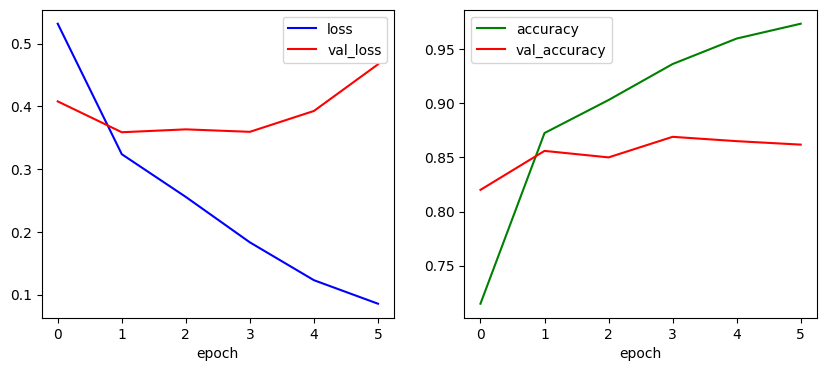

In [8]:
# plot loss and accuracy
plt.figure(figsize=(10,4)) # 그래프 크기 설정
plt.subplot(1,2,1) # 1행 2열 중 첫 번째
plt.plot(results.history['loss'], 'b-', label='loss') # 손실 그래프
plt.plot(results.history['val_loss'], 'r-', label='val_loss') # 검증 손실 그래프
plt.xlabel('epoch') # x축 레이블
plt.legend() # 범례

plt.subplot(1,2,2) # 1행 2열 중 두 번째
plt.plot(results.history['accuracy'], 'g-', label='accuracy') # 정확도 그래프
plt.plot(results.history['val_accuracy'], 'r-', label='val_accuracy') # 검증 정확도 그래프
plt.xlabel('epoch') # x축 레이블
plt.legend() # 범례

plt.show() # 그래프 출력

Evaluate the model

In [9]:
# model = keras.models.load_model('GRU_imdb.keras')
model.evaluate(X_test, y_test) # 테스트, 데이터셋 평가, 첫 번째 값은 손실, 두 번째 값은 정확도

782/782 [==============================] - 22s 28ms/step - loss: 0.5457 - accuracy: 0.8380


[0.5456796288490295, 0.8379999995231628]

### Test Model with a random review

In [ ]:
idx = np.random.randint(X_test.shape[0]) # 랜덤 인덱스 생성
 
X_input = tf.reshape(X_test[idx], shape=(1,-1)) # 입력 데이터셋 형태 변환
 
score = float(tf.squeeze(model.predict(X_input))) # 모델 예측, 스칼라로 변환
 
decision = 1 if score>0.5 else 0 # 결정
rate = score if decision==1 else (1-score) # 확률

print(X_test_str[idx]) # 테스트 데이터셋 출력
 
print('The review is', 'Positive' if decision==1 else 'Negative', 'in {:.2f}% '.format(rate*100)) # 결정 출력

1/1 [==============================] - 1s 821ms/step
The Concorde:Airport'79, Is for now, the last of the high drama high,camp Airport series, At first glance in the TV guide,or DVD cover you would simply think that the film your about to view is as thrilling as the previous Airport's Think Again! What your treated to is 2 hours And 3 Minutes worth of unintentional laughs courtesy of the worst script ever writing it was even penned by Eric Roth, Who brought the world 'Forrest Gump! well one things for sure the script is not Oscar worthy,It's Razzie worthy! The Executives at Universal in '79,done the right thing by marketing this as a 'comedy' Apart from Charo! the film does have an impressive cast list, It's certainly watchable to say the least,
The review is Negative in 98.78% 


(c) 2024 SW Lee